# Predicting hydration free energy corrections terms – project update
Wilson Wu

01.11.2019

## Contents
1. FreeSolv descriptor distribution
1. SAMPL4_Guthrie discrepancy
1. Feature generation
1. SVM setup

## 1. FreeSolv descriptor distribution
- Introduction to Matplotlib and Pandas.
- Refresher for RDKit
- Represent property distribution of the Mobley database using histograms.
- Visualise ligands for property extremes.

### 1.1 Extracting database
Structure data format (SDF) files were exported from GitHub (https://github.com/MobleyLab/FreeSolv) and the tar.gz extracted.

In [1]:
!tar -xf ../jupyter_notebook/sdffiles.tar.gz

### 1.2 Calculating descriptors
Dictionary with keys for entry ID and molecular descriptos was created with empty lists as values.

Mobley IDs and the following molecular descriptors were calcualted and appneded to the dictionary.
1. Molecular weight (MW)
1. Crippen atomic permeability partition coefficient (AlogP)
1. Number of hydrogen bond acceptors (HBA)
1. Number of hydrogen bond donors (HBD)
1. __Active Groups__

In [2]:
from glob import glob
from rdkit.Chem import SDMolSupplier, Descriptors, Crippen, Lipinski, Fragments

# Empty dictionary for ligand IDs and corresponding descriptros.
data = {'ID': [], 'MW (Da)': [], 'AlogP': [], 
        'HBA': [], 'HBD': [], '#NH_OH': [], '#Active groups': []}


def num_active_groups(mol):
    '''Counts the number of active groups in a molecule according to 
    biologically active functional groups.'''
    
    counter = 0
    
    counter += int(Fragments.fr_COO(mol))
    # Carbonyl excluding carboxylic acids
    counter += int(Fragments.fr_C_O_noCOO(mol))
    # Primary amines
    counter += int(Fragments.fr_NH2(mol))
    # Secondary amines
    counter += int(Fragments.fr_NH1(mol))
    # Thiols
    counter += int(Fragments.fr_SH(mol))
    # Sulfonamides
    counter += int(Fragments.fr_sulfonamd(mol))
    # Aromatic rings
    counter += int(Lipinski.NumAromaticRings(mol))
    # Aliphatic hydroxy groups
    counter += int(Fragments.fr_Al_OH(mol))
    # Aromatic hydroxy groups
    counter += int(Fragments.fr_Ar_OH(mol))
        
    return counter

# Location of SDF files.
sdf_dr = '../jupyter_notebook/sdffiles/'

for sdf in glob(sdf_dr + '*.sdf'):
    
    # add ligand Mobley IDs
    ID = sdf.strip('jupyter_notebook/sdffiles/.')
    data['ID'].append(ID)
    
    # add calculated descriptors
    suppl = SDMolSupplier(sdf)
    for mol in suppl:
        data['MW (Da)'].append(Descriptors.MolWt(mol))
        data['AlogP'].append(Crippen.MolLogP(mol))
        data['HBA'].append(Lipinski.NumHAcceptors(mol))
        data['HBD'].append(Lipinski.NumHDonors(mol))
        data['#NH_OH'].append(Lipinski.NHOHCount(mol))
        data['#Active groups'].append(num_active_groups(mol))

Use Pandas to store calculated descriptors and for simple Matplotlib implimentation.

In [3]:
import pandas as pd

df = pd.DataFrame(data)
df

,ID,MW (Da),AlogP,HBA,HBD,#NH_OH,#Active groups
0,mobley_4188615,149.193,1.3884,1,0,0,2
1,mobley_820789,88.106,0.8711,1,1,1,1
2,mobley_1803862,72.151,2.0524,0,0,0,0
3,mobley_1717215,60.052,-0.2108,2,0,0,1
4,mobley_5282042,277.411,4.1686,1,0,0,2
...,...,...,...,...,...,...,...
637,mobley_5123639,102.177,1.4133,1,1,1,1
638,mobley_1075836,88.106,0.5694,2,0,0,1
639,mobley_3515580,124.139,1.4008,2,1,1,2
640,mobley_511661,54.092,1.3584,0,0,0,0


### 1.3 Drug-like chemical space

In [4]:
from matplotlib import pyplot as plt

df.plot(kind='scatter', x='MW (Da)', 
        y='AlogP', color='black', edgecolor='black', s=1)
plt.show()

<Figure size 640x480 with 1 Axes>

### 1.4 Descriptor histograms
A function was written to plot a histogram for any specified DataFrame column.

In [5]:
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

def plot_hist(property):
    '''Enter column name from df as property 
    and specify range() as bin range.'''
    
    min_x = int(df[property].min())
    max_x = int(df[property].max())
    if property == 'MW (Da)':
        bin_range = range(0, 501, 50)
    else:
        bin_range = range(min_x, max_x)
    df[property].plot(kind='hist', bins=bin_range, color='white', edgecolor='black', xticks=bin_range)
    plt.xlabel(property)
    plt.show()

A function to display the 2D structur of the ith structure within a DataFrame sorted in ascending order according to a specified descriptor.

In [6]:
# list of dataframe headings
descriptors = [key for key in data.keys()]
# remove 'ID' key
descriptors.pop(0)

'ID'

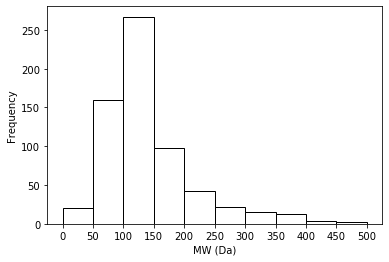

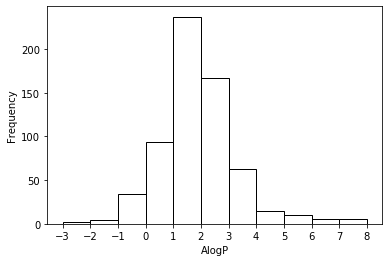

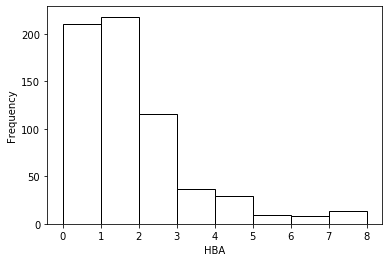

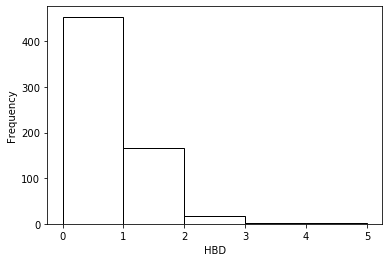

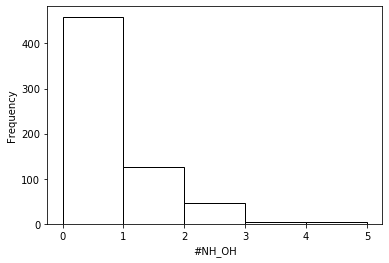

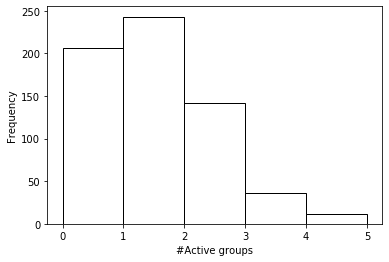

In [7]:
for desc in descriptors:
    plot_hist(desc)

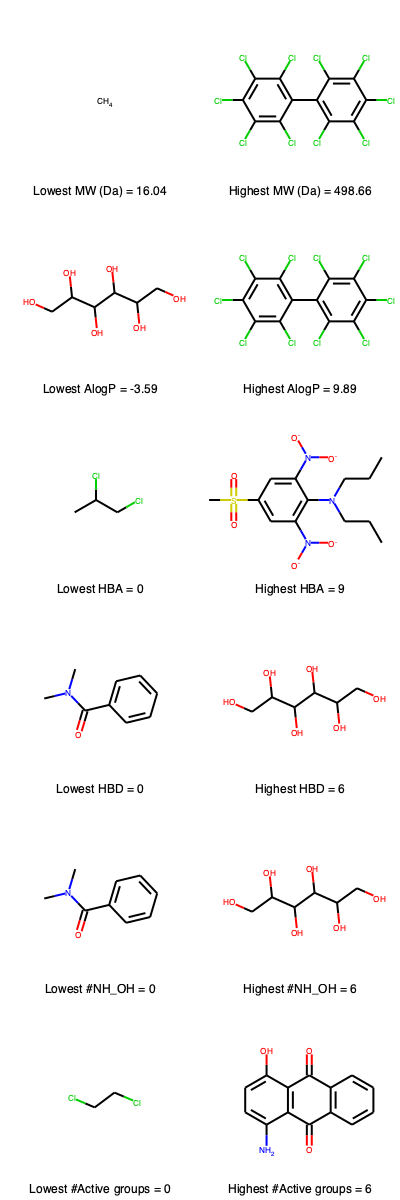

In [8]:
# Empty list for SDF filepaths of ligands with the lowest and highest descriptor values.
low_high_dr = []
# Empty list for descriptor lowet and highest values.
legend = []

for descriptor in descriptors:

    # Sort main df according to descriptor.
    sorted_df = df.sort_values(descriptor)
    sorted_df = sorted_df.reset_index(drop=True)
    
    # Get ID and descriptor df index.
    ID_index = df.columns.get_loc('ID')
    descriptor_index = df.columns.get_loc(descriptor)

    # Provide ID for first and last sturcutre and descriptor.
    ID = [sorted_df.iloc[0, ID_index], sorted_df.iloc[-1, ID_index]]
    for i in range(2):
        low_high_dr.append(sdf_dr + ID[i] + '.sdf')    

    # Provide value for first and last sturcutre and descriptor.
    value = [round(sorted_df.iloc[0, descriptor_index], 2), round(sorted_df.iloc[-1, descriptor_index], 2)]
    legend.append('Lowest ' + str(descriptor) + ' = ' + str(value[0]))
    legend.append('Highest ' + str(descriptor) + ' = ' + str(value[1]))


def draw_structure_panel(sdf_suppl, legend):
    'Draw RDKit.Draw in panel format.'

    suppl = [SDMolSupplier(sdf) for sdf in sdf_suppl]
    mols = [x[0] for x in suppl if x is not None]
    for mol in mols: tmp = AllChem.Compute2DCoords(mol)
    return Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(200, 200), legends=legend)    


draw_structure_panel(low_high_dr, legend)